In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with = engine)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
inspector = inspect(engine)

In [10]:
#get the columns from measurement table
columns_measurement = inspector.get_columns('measurement')
for c in columns_measurement:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

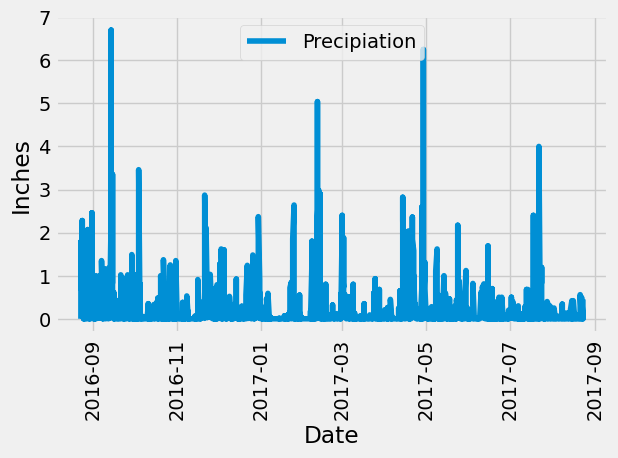

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
first_measurement = dt.datetime(2017,8,23)
# Calculate the date one year from the last date in data set.
one_year = first_measurement - dt.timedelta(days = 366)
# Perform a query to retrieve the data and precipitation scores
data_measurement = session.query(measurement.date,measurement.prcp).\
    filter(measurement.date >= one_year).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
measurement_df = pd.DataFrame(data_measurement, columns = ['date','prcp'])

# Sort the dataframe by date
measurement_df['date'] = pd.to_datetime(measurement_df['date'])
#sorted by date
sorted_df = measurement_df.sort_values(by='date')
#droped null values
cleaned_df = sorted_df.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(cleaned_df['date'],cleaned_df['prcp'],label = 'Precipiation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.legend(loc = 'upper center')
plt.show()


In [13]:
count_prcp = cleaned_df['prcp'].count() #count calculation
mean_prcp = cleaned_df['prcp'].mean() #mean calculation
std_prcp = cleaned_df['prcp'].std() #standard deviation calculation
min_prcp = cleaned_df['prcp'].min() #minimum calculation
twentyfive_prcp = cleaned_df['prcp'].quantile(0.25) #twenty-five percent quanitle
fifty_prcp = cleaned_df['prcp'].quantile(0.5) #fifty percent quanitle
seventyfive_prcp = cleaned_df['prcp'].quantile(0.75) #seventy-five percent quanitle
max_prcp = cleaned_df['prcp'].max() #maximum calculation 

labels = ['Count','Mean', 'STD', 'Min', '25%','%50','%75','Max']

Precipitation = [count_prcp, mean_prcp, std_prcp, min_prcp, twentyfive_prcp, fifty_prcp, seventyfive_prcp, max_prcp]

stats_df = pd.DataFrame({'Stats':labels,'Precipitation': Precipitation})

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
stats_df

,Stats,Precipitation
0,Count,2021.000000
1,Mean,0.177279
2,STD,0.461190
3,Min,0.000000
4,25%,0.000000
5,%50,0.020000
6,%75,0.130000
7,Max,6.700000


# Exploratory Station Analysis

In [15]:
#get the columns from station table
columns_station = inspector.get_columns('station')
for c in columns_station:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [16]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.station)).all()

[(9,)]

In [33]:
stations_query_test = session.query(
    measurement.station).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

# Extracting the station names from the query result
station_names = [station[0] for station in stations_query_test]
station_names

['USC00519281',
 'USC00519397',
 'USC00513117',
 'USC00519523',
 'USC00516128',
 'USC00514830',
 'USC00511918',
 'USC00517948',
 'USC00518838']

In [27]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

stations_query = session.query(
    measurement.station, 
    func.count(measurement.station).label('count')).\
    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

stations_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),   
    func.avg(measurement.tobs)   
).group_by(measurement.station).order_by(func.count(measurement.station).desc()).first()

most_active

(54.0, 85.0, 71.66378066378067)

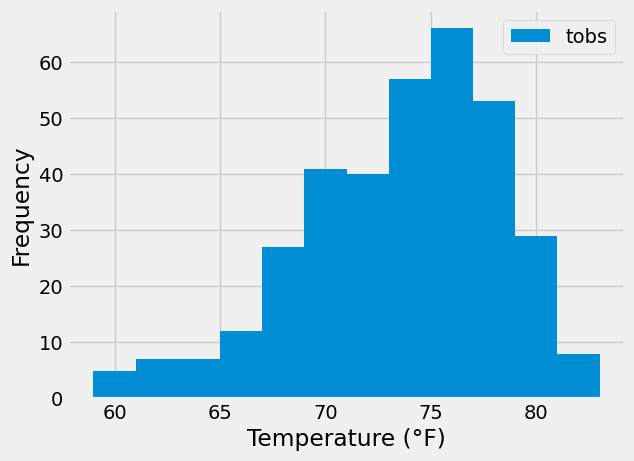

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = session.query(measurement.station,
    func.min(measurement.tobs),
    func.max(measurement.tobs),   
    func.avg(measurement.tobs)   
).group_by(measurement.station).order_by(func.count(measurement.station).desc()).first()


if most_active_station:
    most_active_station_id = most_active_station[0]  # Extract the station ID

    # Calculate the date 12 months ago from most recent
    one_year_ago = first_measurement - dt.timedelta(days = 366)

    temperature_data = session.query(
        measurement.date, measurement.tobs  #'tobs' is the temperature column
    ).filter(
        measurement.station == most_active_station_id,
        measurement.date >= one_year_ago
    ).all()

    #Extract the temperature values for plotting
    temperatures = []
    for temp in temperature_data:
        temperatures.append(temp.tobs)

    # Step 4: Plot the data as a histogram
    plt.hist(temperatures, bins=12, label = 'tobs')
    plt.xlabel('Temperature (°F)')
    plt.ylabel('Frequency')
    plt.legend(loc = 'upper right')
    plt.show()


# Close Session

In [21]:
# Close Session
session.close()